   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 48.7 MB/s eta 0:00:00


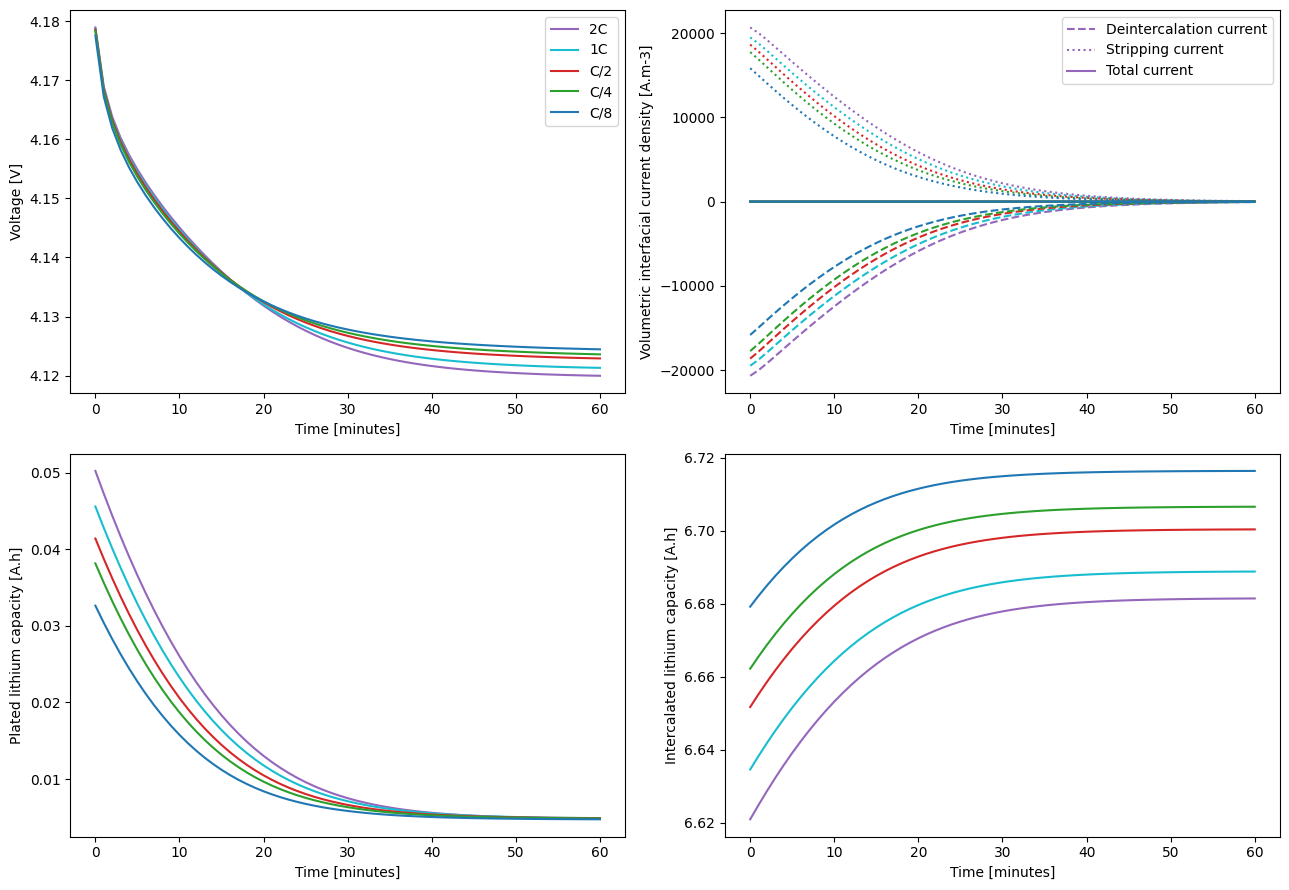

In [ ]:
%pip install "pybamm[plot,cite]" -q
import pybamm
import os

os.chdir(pybamm.__path__[0] + "/..")

plating_options = ["reversible", "irreversible", "partially reversible"]
models = {
    option: pybamm.lithium_ion.DFN(options={"lithium plating": option}, name=option)
    for option in plating_options
}


parameter_values = pybamm.ParameterValues("OKane2022")
parameter_values.update({"Ambient temperature [K]": 268.15})
parameter_values.update({"Upper voltage cut-off [V]": 4.21})
parameter_values.update({"Lithium plating transfer coefficient": 0.5})
parameter_values.update({"Dead lithium decay constant [s-1]": 1e-4})
pybamm.citations.register("Ren2018")

s = pybamm.step.string
experiment_discharge = pybamm.Experiment(
    [
        (
            s("Discharge at C/20 until 2.5 V", period="10 minutes"),
            s("Rest for 1 hour", period="3 minutes"),
        ),
    ]
)

sims_discharge = []
for model in models.values():
    sim_discharge = pybamm.Simulation(
        model, parameter_values=parameter_values, experiment=experiment_discharge
    )
    sol_discharge = sim_discharge.solve(calc_esoh=False)
    model.set_initial_conditions_from(sol_discharge, inplace=True)
    sims_discharge.append(sim_discharge)

C_rates = ["2C", "1C", "C/2", "C/4", "C/8"]
experiments = {}
for C_rate in C_rates:
    experiments[C_rate] = pybamm.Experiment(
        [
            (
                f"Charge at {C_rate} until 4.2 V",
                "Hold at 4.2 V until C/20",
                "Rest for 1 hour",
            )
        ]
    )

C_rates = ["2C", "1C", "C/2", "C/4", "C/8"]
experiments = {}
for C_rate in C_rates:
    experiments[C_rate] = pybamm.Experiment(
        [
            (
                f"Charge at {C_rate} until 4.2 V",
                "Hold at 4.2 V until C/20",
                "Rest for 1 hour",
            )
        ]
    )

def define_and_solve_sims(model, experiments, parameter_values):
    sims = {}
    for C_rate, experiment in experiments.items():
        sim = pybamm.Simulation(
            model, experiment=experiment, parameter_values=parameter_values
        )
        sim.solve(calc_esoh=False)
        sims[C_rate] = sim

    return sims


sims_reversible = define_and_solve_sims(
    models["reversible"], experiments, parameter_values
)

colors = ["tab:purple", "tab:cyan", "tab:red", "tab:green", "tab:blue"]
linestyles = ["dashed", "dotted", "solid"]

param = models["reversible"].param
A = parameter_values.evaluate(param.L_y * param.L_z)
F = parameter_values.evaluate(param.F)
L_n = parameter_values.evaluate(param.n.L)

currents = [
    "X-averaged negative electrode volumetric interfacial current density [A.m-3]",
    "X-averaged negative electrode lithium plating volumetric interfacial current density [A.m-3]",
    "Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]",
]


def plot(sims):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))
    for (C_rate, sim), color in zip(sims.items(), colors):

        sol = sim.solution.cycles[0].steps[2]


        t = sol["Time [min]"].entries
        t = t - t[0]
        V = sol["Voltage [V]"].entries
        axs[0, 0].plot(t, V, color=color, linestyle="solid", label=C_rate)


        for current, ls in zip(currents, linestyles):
            j = sol[current].entries
            axs[0, 1].plot(t, j, color=color, linestyle=ls)


        Q_Li = sol["Loss of capacity to negative lithium plating [A.h]"].entries
        axs[1, 0].plot(t, Q_Li, color=color, linestyle="solid")


        Q_main = (
            sol["Negative electrode volume-averaged concentration [mol.m-3]"].entries
            * F
            * A
            * L_n
            / 3600
        )
        axs[1, 1].plot(t, Q_main, color=color, linestyle="solid")

    axs[0, 0].legend()
    axs[0, 0].set_ylabel("Voltage [V]")
    axs[0, 1].set_ylabel("Volumetric interfacial current density [A.m-3]")
    axs[0, 1].legend(("Deintercalation current", "Stripping current", "Total current"))
    axs[1, 0].set_ylabel("Plated lithium capacity [A.h]")
    axs[1, 1].set_ylabel("Intercalated lithium capacity [A.h]")

    for ax in axs.flat:
        ax.set_xlabel("Time [minutes]")

    fig.tight_layout()

    return fig, axs


plot(sims_reversible);

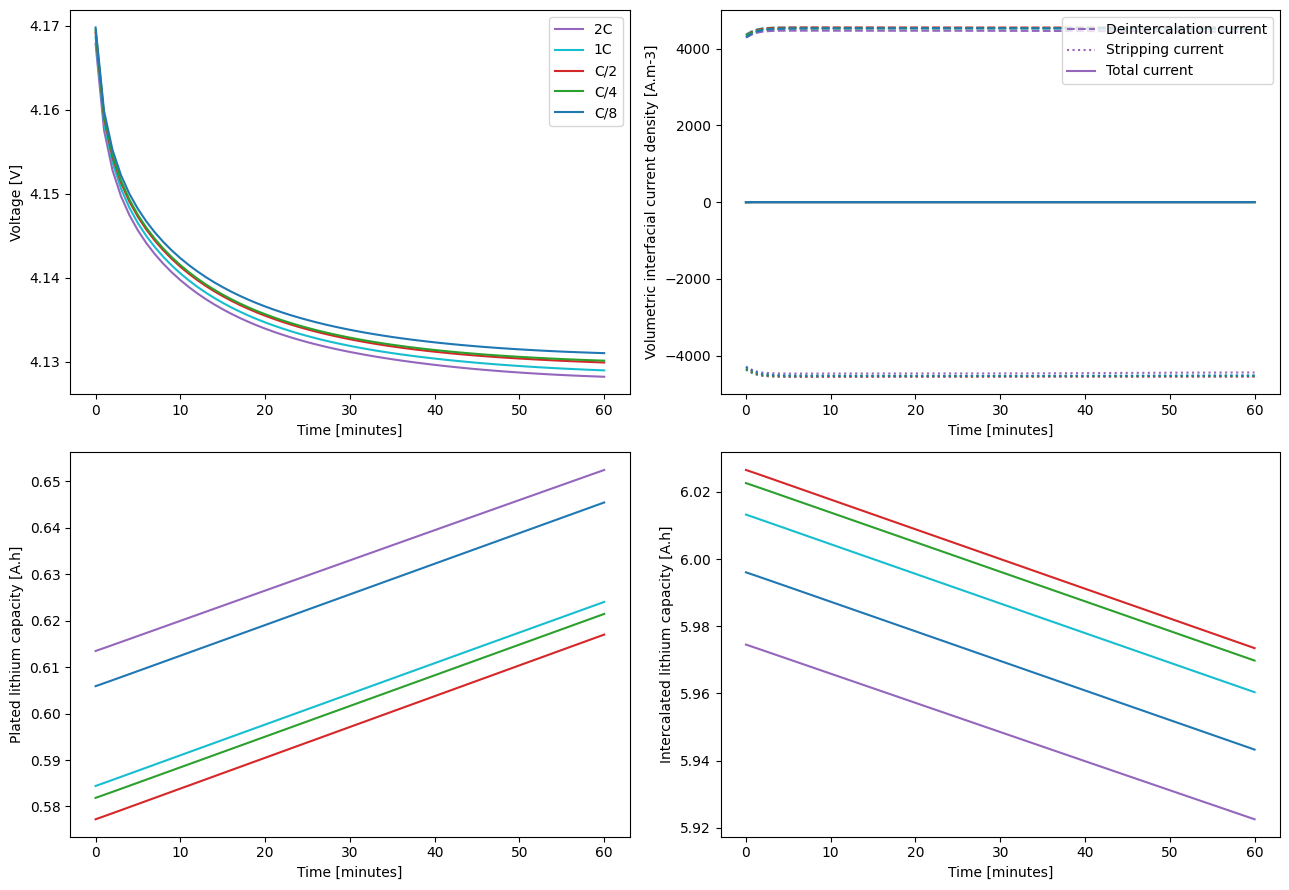

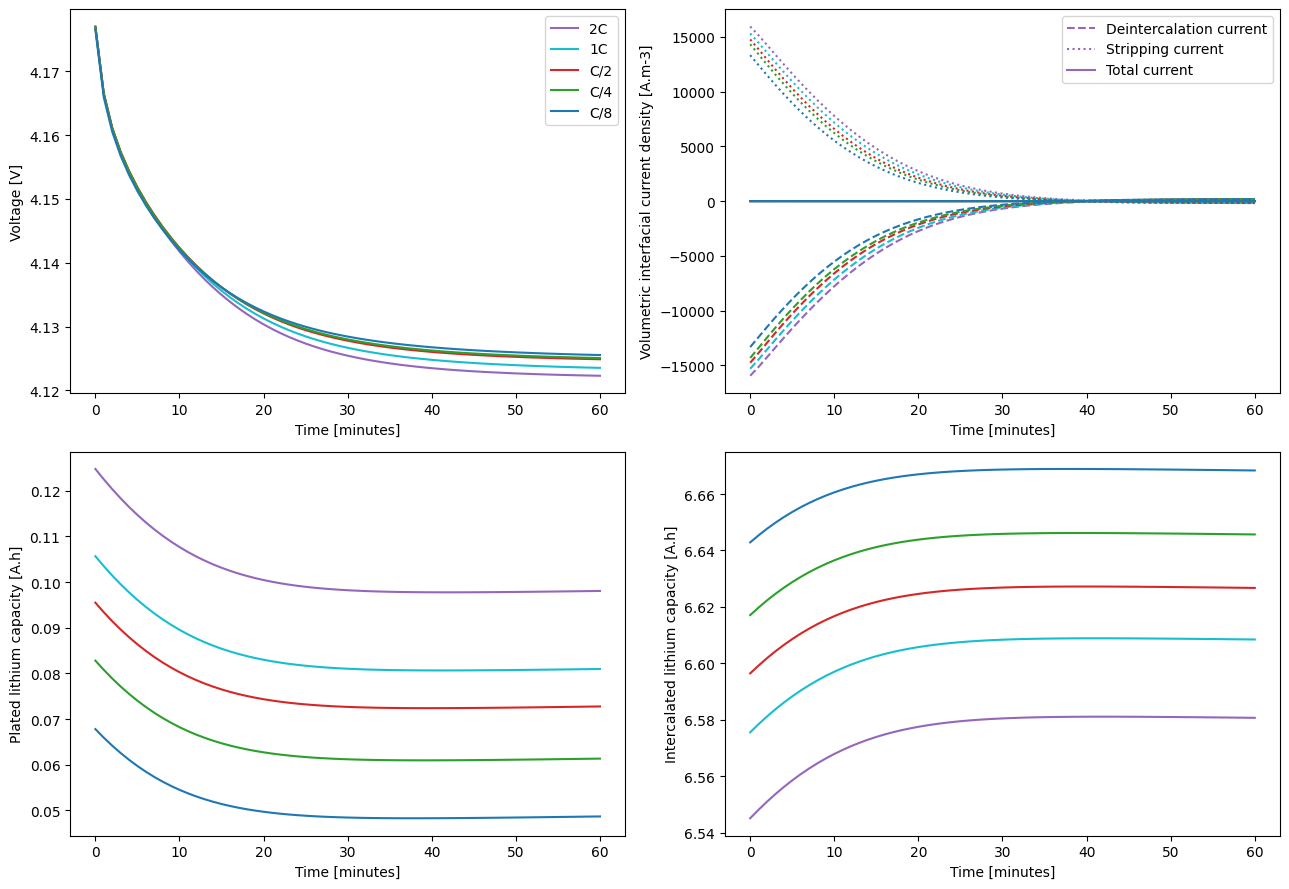

In [ ]:
sims_irreversible = define_and_solve_sims(
    models["irreversible"], experiments, parameter_values
)
plot(sims_irreversible);
sims_partially_reversible = define_and_solve_sims(
    models["partially reversible"], experiments, parameter_values
)

plot(sims_partially_reversible);